In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
# import PIL
import tensorflow as tf
import tensorflow_probability as tfp
# import tensorflow.contrib as tf_contrib
import time

from data_utils import *

2022-09-28 17:02:52.282688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model Creation

In [2]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])


class SelfAttention(tf.keras.layers.Layer):
    """ Adapted from the Zhang, Goodfellow, et al. paper """

    # weight_init = tf_contrib.layers.xavier_initializer()
    weight_regularizer = None
    weight_regularizer_fully = None

    def __init__(self, sess, args):
        #My new inputs
        self.channels = args.channels


        self.model_name = "SAGAN"  # name for checkpoint
        self.sess = sess
        self.dataset_name = args.dataset
        self.checkpoint_dir = args.checkpoint_dir
        self.sample_dir = args.sample_dir
        self.result_dir = args.result_dir
        self.log_dir = args.log_dir

        self.epoch = args.epoch
        self.iteration = args.iteration
        self.batch_size = args.batch_size
        self.print_freq = args.print_freq
        self.save_freq = args.save_freq
        self.img_size = args.img_size

        """ Generator """
        self.layer_num = int(np.log2(self.img_size)) - 3
        self.z_dim = args.z_dim  # dimension of noise-vector
        self.gan_type = args.gan_type

        """ Discriminator """
        self.n_critic = args.n_critic
        self.sn = args.sn
        self.ld = args.ld


        self.sample_num = args.sample_num  # number of generated images to be saved
        self.test_num = args.test_num


        # train
        self.g_learning_rate = args.g_lr
        self.d_learning_rate = args.d_lr
        self.beta1 = args.beta1
        self.beta2 = args.beta2

        self.custom_dataset = False

    def _spectral_norm(w, iteration=1):
        w_shape = w.shape.as_list()
        w = tf.reshape(w, [-1, w_shape[-1]])

        u = tf.get_variable("u", [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

        u_hat = u
        v_hat = None
        for i in range(iteration):
            """
            power iteration
            Usually iteration = 1 will be enough
            """
            v_ = tf.matmul(u_hat, tf.transpose(w))
            v_hat = tf.nn.l2_normalize(v_)

            u_ = tf.matmul(v_hat, w)
            u_hat = tf.nn.l2_normalize(u_)

        u_hat = tf.stop_gradient(u_hat)
        v_hat = tf.stop_gradient(v_hat)

        sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

        with tf.control_dependencies([u.assign(u_hat)]):
            w_norm = w / sigma
            w_norm = tf.reshape(w_norm, w_shape)

        return w_norm    

    def _conv(x, channels, kernel=4, stride=2, pad=0, pad_type='zero', use_bias=True, sn=False, scope='conv_0'):
        with tf.variable_scope(scope):
            if pad > 0:
                h = x.get_shape().as_list()[1]
                if h % stride == 0:
                    pad = pad * 2
                else:
                    pad = max(kernel - (h % stride), 0)

                pad_top = pad // 2
                pad_bottom = pad - pad_top
                pad_left = pad // 2
                pad_right = pad - pad_left

                if pad_type == 'zero':
                    x = tf.pad(x, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]])
                if pad_type == 'reflect':
                    x = tf.pad(x, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], mode='REFLECT')

            if sn:
                w = tf.get_variable("kernel", shape=[kernel, kernel, x.get_shape()[-1], channels], initializer=weight_init,
                                    regularizer=weight_regularizer)
                x = tf.nn.conv2d(input=x, filter=spectral_norm(w),
                                strides=[1, stride, stride, 1], padding='VALID')
                if use_bias:
                    bias = tf.get_variable("bias", [channels], initializer=tf.constant_initializer(0.0))
                    x = tf.nn.bias_add(x, bias)

            else:
                x = tf.layers.conv2d(inputs=x, filters=channels,
                                    kernel_size=kernel, kernel_initializer=weight_init,
                                    kernel_regularizer=weight_regularizer,
                                    strides=stride, use_bias=use_bias)

            return x



    def _hw_flatten(x) :
        return tf.reshape(x, shape=[x.shape[0], -1, x.shape[-1]])

    def _attention(self, x, channels, scope='attention'):
        with tf.variable_scope(scope):

            f = conv(x, channels // 8, kernel=1, stride=1, sn=self.sn, scope='f_conv') # [bs, h, w, c']
            g = conv(x, channels // 8, kernel=1, stride=1, sn=self.sn, scope='g_conv') # [bs, h, w, c']
            h = conv(x, channels, kernel=1, stride=1, sn=self.sn, scope='h_conv') # [bs, h, w, c]

            # N = h * w
            s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True) # # [bs, N, N]

            beta = tf.nn.softmax(s)  # attention map

            o = tf.matmul(beta, hw_flatten(h)) # [bs, N, C]
            gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

            o = tf.reshape(o, shape=x.shape) # [bs, h, w, C]
            o = conv(o, channels, kernel=1, stride=1, sn=self.sn, scope='attn_conv')

            x = gamma * o + x

        return x

    def _build_module(self):

        attention_block = self.attention()



### A simplified attention block
def hw_flatten(x) :
    # return tf.reshape(x, shape=[x.shape[0], -1, x.shape[-1]])
    return tf.reshape(x, shape=(x.shape[0], -1, x.shape[-1]))

def attention(x, channels=265):

    f = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same', use_bias=True)(x) # [bs, h, w, c']
    g = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same', use_bias=True)(x) # [bs, h, w, c']
    h = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same', use_bias=True)(x) # [bs, h, w, c]
    # print('h', h.shape)
    # N = h * w
    # s = tf.linalg.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True) # # [bs, N, N]
    s = tf.matmul(g, f, transpose_b=True) # # [bs, N, N]
    # s = tf.matmul(tf.keras.layers.Flatten()(g), tf.keras.layers.Flatten()(f), transpose_b=True) # # [bs, N, N]
    # print('s', s.shape)
    beta = tf.nn.softmax(s)  # attention map
    # print('beta', beta.shape)

    # o = tf.linalg.matmul(beta, hw_flatten(h)) # [bs, N, C]
    o = tf.matmul(beta, h) # [bs, N, C]
    # o = tf.linalg.matmul(beta, tf.keras.layers.Flatten()(h)) # [bs, N, C]
    # print('o', o.shape)
    # Unsure if this is correct, see documentation: https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable#migrate-to-tf2
    gamma = tf.compat.v1.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

    # o = tf.reshape(o, shape=x.shape) # [bs, h, w, C]
    o = tf.keras.layers.Conv2D(filters=channels, kernel_size=1, strides=1, padding='same', use_bias=True)(o)

    x = gamma * o + x

    return x

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # this formula is considered best practice


In [6]:
def Conv3D_Block(inp_shape):
        inp = tf.keras.layers.Input(shape=inp_shape)

        # We will construct 4 `ConvLSTM2D` layers with batch normalization,
        # followed by a `Conv3D` layer for the spatiotemporal outputs.
        x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3), padding="same", return_sequences=True, activation="relu")(inp)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3), padding="same", return_sequences=True, activation="relu")(inp)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ConvLSTM2D(filters=8, kernel_size=(3), padding="same", return_sequences=True, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ConvLSTM2D(filters=4, kernel_size=(3), padding="same", return_sequences=True, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        res1 = tf.keras.layers.Conv3D(filters=1, kernel_size=(1,1,1), padding="same")(x)
        res1 = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(res1)
        res1 = tf.keras.layers.LeakyReLU(alpha=0.05)(res1)
        res1 = tf.keras.layers.BatchNormalization()(res1)
        # attention
        x = attention(res1, channels=265)
        # residual
        x = tf.keras.layers.Add()([res1, x])
        x = tf.keras.layers.Dense(64,activation='relu')(x)
        x = tf.keras.layers.Dense(32,activation='relu')(x)
        x = tf.keras.layers.Dense(16,activation='relu')(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.05)(x)

        # Next, we will build the complete model and compile it.
        model = tf.keras.Model(inputs=inp, outputs=x)
        return model

In [7]:
def encoder_model(latent_dim, batch_size):
    """ Adapted from Laurence Moroney's Coursera course on VAEs: https://www.coursera.org/lecture/generative-deep-learning-with-tensorflow/sampling-layer-and-encoder-G2mJr"""
    demand_model = Conv3D_Block((batch_size, 265,265,1))
    ex_f_model = Conv3D_Block((batch_size, 265,265,1))
    combined = tf.keras.layers.concatenate([demand_model.output, ex_f_model.output], axis=-1)
    x = tf.keras.layers.Dense(64, activation='relu')(combined)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(inputs=[demand_model.input, ex_f_model.input], outputs=[z_mean, z_log_var, z], name="encoder")
    return encoder

In [14]:
latent_dim = 4
batch_size = 32 # Paper: 32
encoder = encoder_model(latent_dim, batch_size)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 265, 26  0           []                               
                                5, 1)]                                                            
                                                                                                  
 input_8 (InputLayer)           [(None, 32, 265, 26  0           []                               
                                5, 1)]                                                            
                                                                                                  
 conv_lstm2d_22 (ConvLSTM2D)    (None, 32, 265, 265  9856        ['input_7[0][0]']                
                                , 16)                                                       

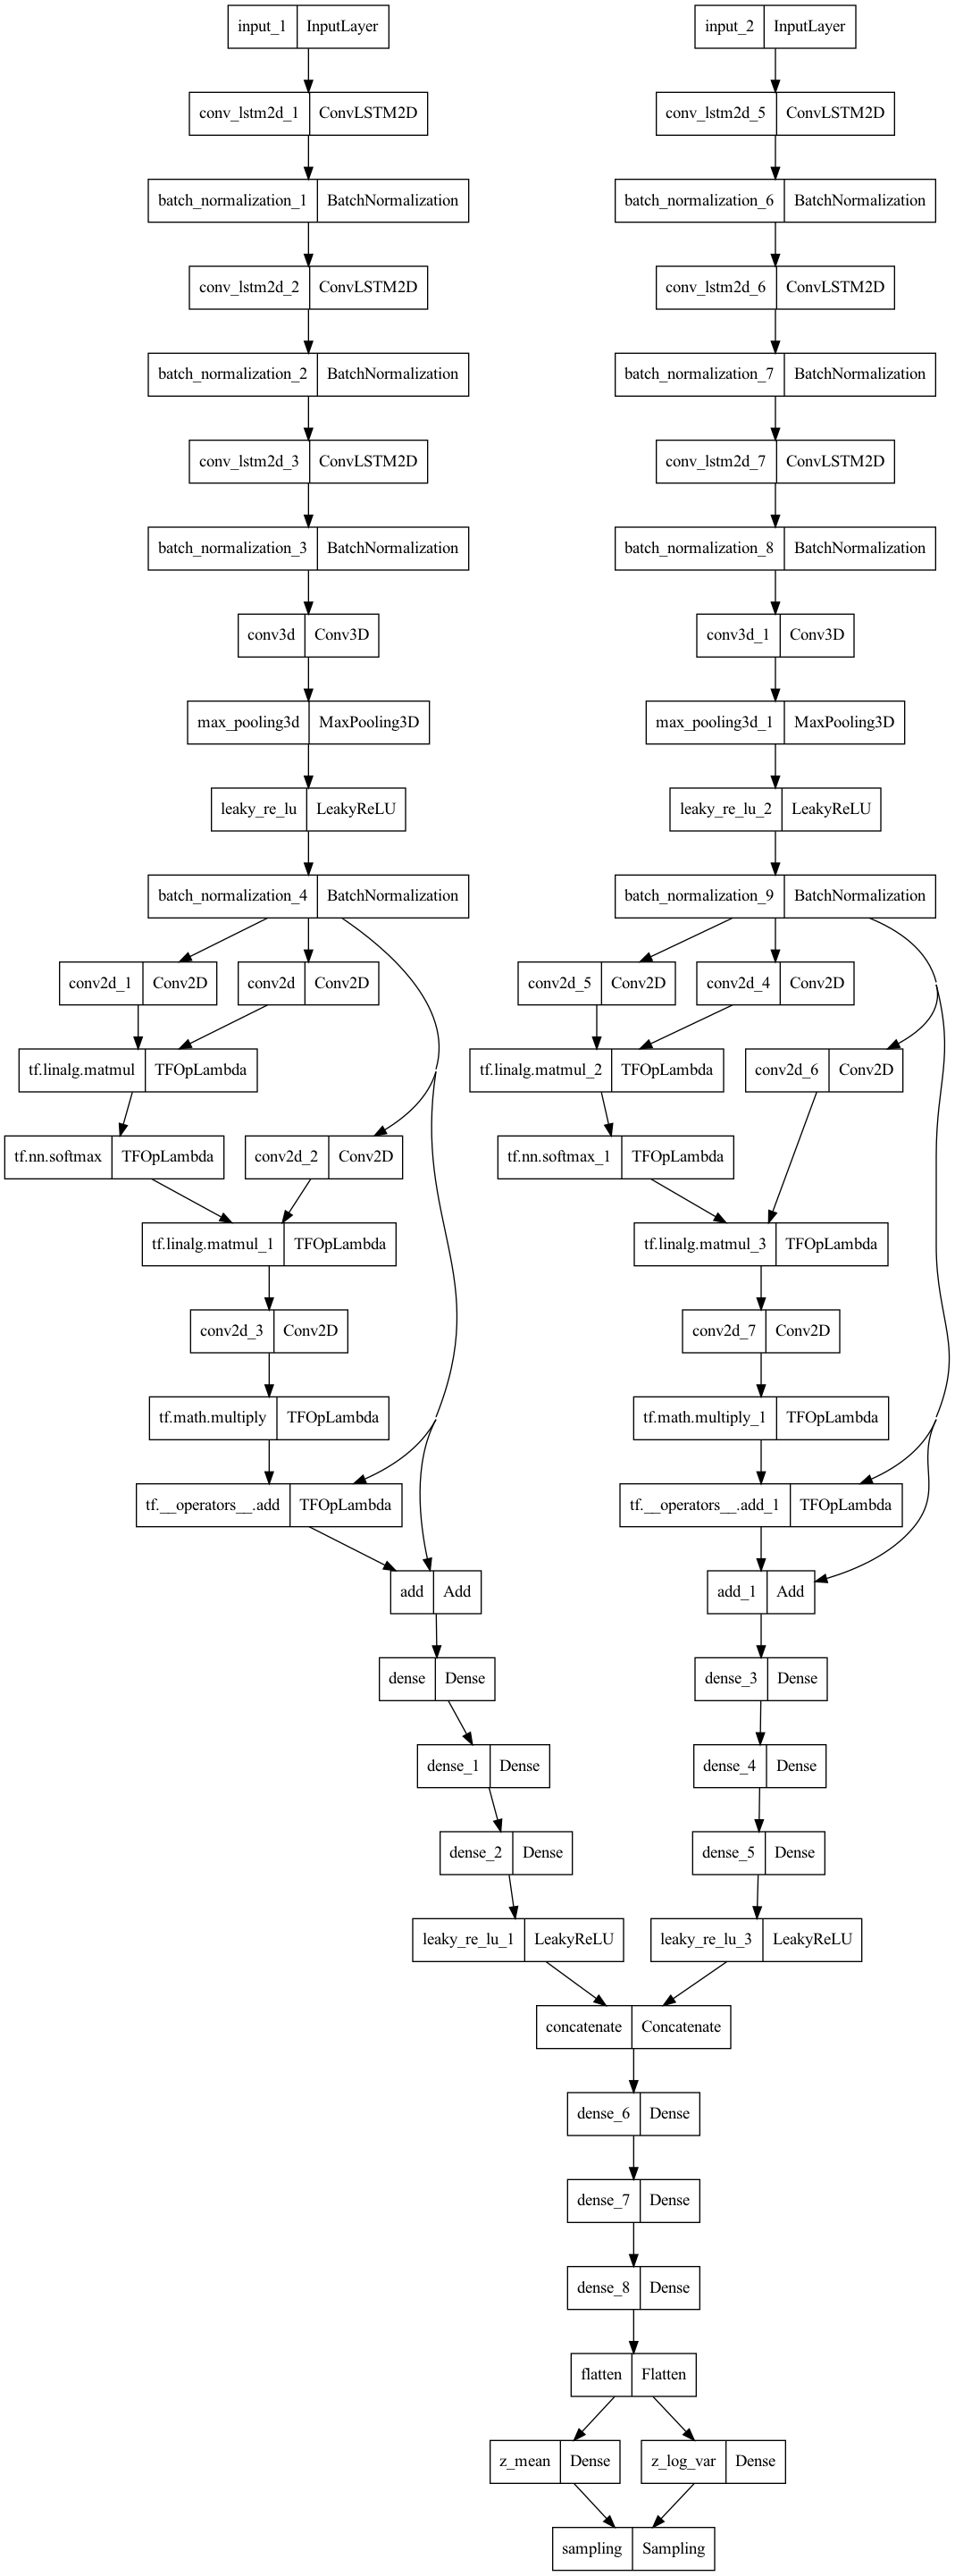

In [8]:
tf.keras.utils.plot_model(encoder, 'model.png')

In [17]:
def generator_model(latent_dim):
    latent_inputs = tf.keras.Input(shape=(latent_dim,265,265,1))
    x = tf.keras.layers.Dense(16, activation='relu')(latent_inputs)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.ConvLSTM2D(filters=4, kernel_size=(3), padding="same", return_sequences=True, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ConvLSTM2D(filters=8, kernel_size=(3), padding="same", return_sequences=True, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3), padding="same", return_sequences=True, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3), padding="same", return_sequences=True, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv3D(filters=1, kernel_size=(3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.05)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # generator = tf.keras.Model(latent_inputs, outputs=[x_real, x_enc, x_fake], name="generator")
    generator = tf.keras.Model(latent_inputs, outputs=x, name="generator")
    return generator

In [18]:
generator = generator_model(latent_dim)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 4, 265, 265, 1)]  0         
                                                                 
 dense_30 (Dense)            (None, 4, 265, 265, 16)   32        
                                                                 
 dense_31 (Dense)            (None, 4, 265, 265, 32)   544       
                                                                 
 dense_32 (Dense)            (None, 4, 265, 265, 64)   2112      
                                                                 
 conv_lstm2d_33 (ConvLSTM2D)  (None, 4, 265, 265, 4)   9808      
                                                                 
 batch_normalization_39 (Bat  (None, 4, 265, 265, 4)   16        
 chNormalization)                                                
                                                         

# Data Loading

In [9]:
# Yuri's computer
df = load_data('/Users/probook/Documents/GitHub/mobilityforecast/data', 'yellow_tripdata_2022-01.parquet', data_type='parquet')
df_bike = load_data('/Users/probook/Documents/GitHub/mobilityforecast/data', '202201-citibike-tripdata.csv', data_type='csv')
df_weather = load_data('/Users/probook/Documents/GitHub/mobilityforecast/data', 'manhattan.csv', data_type='csv')
# Anup's computer

/Users/probook/Documents/GitHub/mobilityforecast/src/data_utils.py:35: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_dir, data_file))


In [10]:
st_map_taxi = data_preprocessing(df, data_type='Taxi', year=2022, month=1, dropna=True, num_bins=10)

st_map_bike = data_preprocessing(df_bike, data_type='CitiBike', year=2022, month=1, dropna=True, num_bins=10)

st_map_weather = data_preprocessing(df_weather, data_type='Weather', year=2021, month=1, dropna=True, num_bins=10)

In [12]:
scaled_taxi = scale_data(st_map_taxi)
scaled_bike = scale_data(st_map_bike)
scaled_weather = scale_data(st_map_weather)

In [13]:
taxi_train, taxi_test = split_data(scaled_taxi, n_splits=5)
bike_train, bike_test = split_data(scaled_bike, n_splits=5)
weather_train, weather_test = split_data(scaled_weather, n_splits=5)

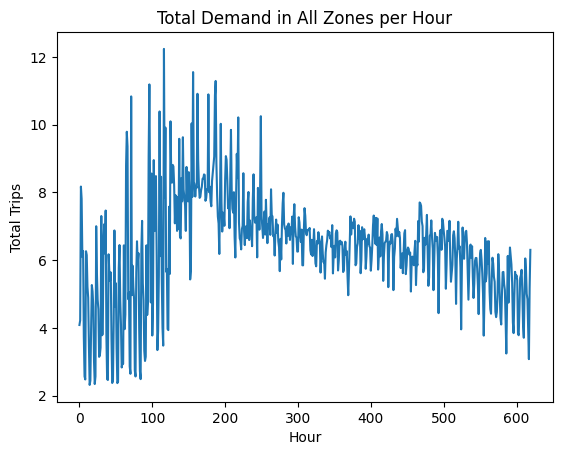

In [7]:
plot_map(taxi_train)